# Model Prototype

Training an LSTM model to predict future bitcoin prices given the return values and trend values

In [1]:
from pandas import read_csv, DataFrame, concat, to_datetime
from numpy import log
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, Activation, Dense, Dropout, Flatten
from keras.layers import LSTM
from keras import Model
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

Using TensorFlow backend.


### Load and reshape data

In [2]:
# load dataset and separate dates
price_df = read_csv('../btc_predict/data/raw/btc_price.csv')
trend_df = read_csv('../btc_predict/data/raw/btc_trend.csv')

btc_df = price_df.merge(trend_df, on='date', how='inner')
btc_df = btc_df.set_index('date')
btc_df.index = to_datetime(btc_df.index)
btc_df = btc_df.reindex(index=btc_df.index[::-1])
# select only relevant columns, 'bitcoin' is the default name for the trend column
btc_df = btc_df[['close', 'bitcoin']]

# take the log difference
btc_df['close'] = log(btc_df['close']) - \
    log(btc_df['close'].shift(1))
btc_df['bitcoin'] = log(btc_df['bitcoin']) - \
    log(btc_df['bitcoin'].shift(1))
btc_df.columns = ['log_returns', 'log_trend_chg']
btc_df = btc_df[1:]

In [3]:
# reshape the data so that y is the next time step with forecast sequence
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# reshape time series
look_back = 10
dataset = series_to_supervised(btc_df, n_in=look_back)
# drop var2(t) since var1(t) is target
dataset.drop(dataset.columns[len(dataset.columns)-1], axis=1, inplace=True)

In [4]:
dataset.head()

,var1(t-10),var2(t-10),var1(t-9),var2(t-9),var1(t-8),var2(t-8),var1(t-7),var2(t-7),var1(t-6),var2(t-6),...,var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
date,,,,,,,,,,,,,,,,,,,,,
2014-01-12,0.039388,0.122602,0.020147,0.074108,0.048620,-0.154151,0.082611,0.154151,0.020946,0.223144,...,-0.089612,0.049526,0.000000,0.004901,-0.031749,0.025209,0.031749,0.051031,-0.133531,-0.057106
2014-01-13,0.020147,0.074108,0.048620,-0.154151,0.082611,0.154151,0.020946,0.223144,-0.172811,-0.089612,...,0.000000,0.004901,-0.031749,0.025209,0.031749,0.051031,-0.133531,-0.057106,0.000000,-0.025840
2014-01-14,0.048620,-0.154151,0.082611,0.154151,0.020946,0.223144,-0.172811,-0.089612,0.049526,0.000000,...,-0.031749,0.025209,0.031749,0.051031,-0.133531,-0.057106,0.000000,-0.025840,0.000000,-0.009472
2014-01-15,0.082611,0.154151,0.020946,0.223144,-0.172811,-0.089612,0.049526,0.000000,0.004901,-0.031749,...,0.031749,0.051031,-0.133531,-0.057106,0.000000,-0.025840,0.000000,-0.009472,0.000000,0.032621
2014-01-16,0.020946,0.223144,-0.172811,-0.089612,0.049526,0.000000,0.004901,-0.031749,0.025209,0.031749,...,-0.133531,-0.057106,0.000000,-0.025840,0.000000,-0.009472,0.000000,0.032621,0.035091,-0.029792


In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[:train_size], dataset[train_size:len(dataset)]

In [52]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset.values[:train_size], dataset.values[train_size:len(dataset)]

# split in X and y
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

# scale on training data
scale_x = StandardScaler()
X_train = scale_x.fit_transform(X_train)
X_test = scale_x.transform(X_test)
scale_y = StandardScaler()
y_train = scale_y.fit_transform(y_train.reshape(-1, 1))
y_test = scale_y.transform(y_test.reshape(-1, 1))

# reshape input to be 3D [samples, timesteps, features] for LSTM input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

### Dummy comparison models

In [50]:
# evaluate dummy models for comparison
for strategy in ['mean', 'median', 'constant']:
    
    if strategy=='constant':
        dummy=DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy=DummyRegressor(strategy=strategy)
        
    print('\nTraining dummy model on training data with strategy {} ...'.format(strategy))
    dummy.fit(X_train, y_train)
    
    print('\nPerformance on train data:')
    dummy_predict_train = dummy.predict(X_train)
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_train, y_pred=dummy_predict_train)))
    
    print('\nPerformance on test data:')
    dummy_predict_test = dummy.predict(X_test)
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_test, y_pred=dummy_predict_test)))


Training dummy model on training data with strategy mean ...

Performance on train data:
mean MSE: 1.0

Performance on test data:
mean MSE: 0.7522596422630953

Training dummy model on training data with strategy median ...

Performance on train data:
median MSE: 1.0000814729916712

Performance on test data:
median MSE: 0.752773517489407

Training dummy model on training data with strategy constant ...

Performance on train data:
constant MSE: 1.0

Performance on test data:
constant MSE: 0.7522596422630953


### LSTM Model

As this is just an expository project we aren't looking for fantastic results. For one, the dataset being used is very small compared to the data required to get good results with an LSTM. Additionally, the parameters dropout, nodes, epochs, and batch_size were tuned by hand due to computation constraints. With more resources the parameters could be better tuned by using a nested cross-validation technique such as day forward-chaining. 

In [51]:
dropout = 0.7
nodes = 16
epochs = 20
batch_size = 10

model = Sequential()
model.add(LSTM(nodes, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))
model.add(LSTM(nodes))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=epochs, verbose=1, shuffle=False, 
                    batch_size=batch_size, validation_data=(X_test, y_test))
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Train on 1544 samples, validate on 662 samples
Epoch 1/20
1544/1544 [==============================] - 26s 17ms/step - loss: 0.9972 - val_loss: 0.7602
Epoch 2/20
1544/1544 [==============================] - 8s 5ms/step - loss: 1.0062 - val_loss: 0.7573
Epoch 3/20
1544/1544 [==============================] - 7s 4ms/step - loss: 1.0016 - val_loss: 0.7558
Epoch 4/20
1544/1544 [==============================] - 7s 4ms/step - loss: 0.9998 - val_loss: 0.7550
Epoch 5/20
1544/1544 [==============================] - 7s 5ms/step - loss: 0.9965 - val_loss: 0.7552
Epoch 6/20
1544/1544 [==============================] - 7s 4ms/step - loss: 0.9966 - val_loss: 0.7564
Epoch 7/20
1544/1544 [==============================] - 8s 5ms/step - loss: 0.9992 - val_loss: 0.7560
Epoch 8/20
1544/1544 [==============================] - 7s 5ms/step - loss: 0.9939 - val_loss: 0.7555
Epoch 9/20
 780/1544 [==============>...............] - ETA: 2s - loss: 0.8507

KeyboardInterrupt: 

In [9]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


### Diagnostics

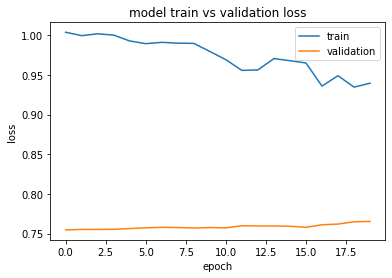

In [44]:
# train and validation loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

The train and validation loss don't quite converge but with such small data these were the best results with tuning by hand. Tuning either way gives clear over- and under-fitting. There is also an interesting occurence where the validation loss is lower than the training loss which can be caused by the validation cases not using dropout in their evaluation, but this still appears when the dropout layer is taken away.

In [10]:
# calculate mean squared error
train_score = mean_squared_error(y_train, train_predict[:,0])
print('Train Score: %.4f MSE' % (train_score))
test_score = mean_squared_error(y_test, test_predict[:,0])
print('Test Score: %.4f MSE' % (test_score))

Train Score: 0.9997 MSE
Test Score: 0.7541 MSE


Significantly better than the dummy cases. Would like to compare to other models such as ARIMA or XGBOOST as well as compare results without using the trend variable. 

In [11]:
# inverse scale target and predictions
y_train = scale_y.inverse_transform(y_train)
y_test = scale_y.inverse_transform(y_test)
test_predict = scale_y.inverse_transform(test_predict)
train_predict = scale_y.inverse_transform(train_predict)

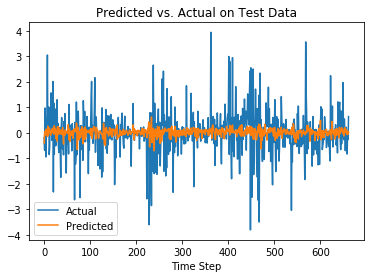

In [45]:
# compare predicitons on test data
plt.plot(y_test)
plt.plot(test_predict)
plt.xlabel('Time Step')
plt.title('Predicted vs. Actual on Test Data')
plt.legend(['Actual', 'Predicted'])
plt.show()

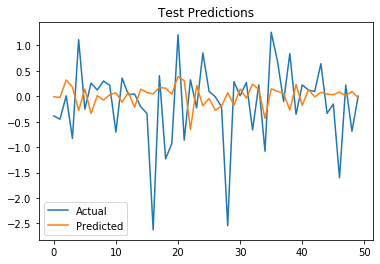

In [46]:
# closer look
plt.plot(y_test[50:100])
plt.plot(test_predict[50:100])
plt.title('Test Predictions')
plt.legend(['Actual', 'Predicted'])
plt.show()

One potential problem with using LSTMs on time-series data is the possibility of the model learning a lagged version of the input, we can see that this isn't the case with these predictions.

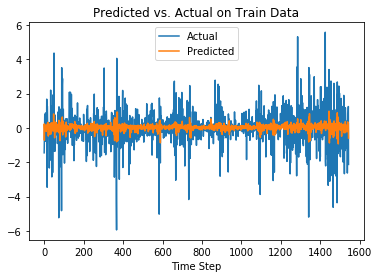

In [47]:
# compare predictions on train data
plt.plot(y_train)
plt.plot(train_predict)
plt.xlabel('Time Step')
plt.title('Predicted vs. Actual on Train Data')
plt.legend(['Actual', 'Predicted'])
plt.show()

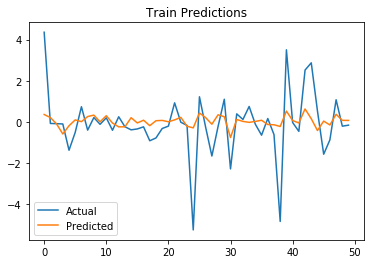

In [48]:
plt.plot(y_train[50:100])
plt.plot(train_predict[50:100])
plt.title('Train Predictions')
plt.legend(['Actual', 'Predicted'])
plt.show()